## EDA New York state hospitals

We want to analyse the hospital distribution in the state of New York. In order to do that we first need to:
1. Convert point column to geopandas Point, required for lat long representation.
2. Extract a subset of data which only contains info about the state of New York.
3. Load Civil Boundaries data for better visualization of counties and cities in the state.
4. Plot the distribution of Hospitals and Civil Boundaries.
5. Plot the distribution of Hospitals and popuplation density together.

### Import modules

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon
import contextily as cx
import matplotlib.colors as colors
import warnings

warnings.filterwarnings('ignore')

### Load Dataset Reported Patient Impact and Hospital Capacity by Facility - Weekly

Read csv in pandas and convert hospital address column to `Geopandas Point` datatype

In [6]:
df = pd.read_csv('../data/raw_datasets/COVID-19_Reported_Patient_Impact_and_Hospital_Capacity_by_Facility.csv', parse_dates=['collection_week'])
# convert hospital address to Geopandas Point
df['geocoded_hospital_address'] = gpd.GeoSeries.from_wkt(df['geocoded_hospital_address'])
df.head()

,hospital_pk,collection_week,state,ccn,hospital_name,address,city,zip,hospital_subtype,fips_code,...,previous_day_admission_pediatric_covid_confirmed_7_day_coverage,previous_day_admission_adult_covid_suspected_7_day_coverage,previous_day_admission_pediatric_covid_suspected_7_day_coverage,previous_week_personnel_covid_vaccinated_doses_administered_7_day,total_personnel_covid_vaccinated_doses_none_7_day,total_personnel_covid_vaccinated_doses_one_7_day,total_personnel_covid_vaccinated_doses_all_7_day,previous_week_patients_covid_vaccinated_doses_one_7_day,previous_week_patients_covid_vaccinated_doses_all_7_day,is_corrected
0,28TA03,2022-02-18,NE,28TA03,MADONNA REHABILITATION SPECIALTY HOSPITAL OMAHA,17500 BURKE STREET,OMAHA,68118.0,Long Term,31055.0,...,1,1,1,21.0,78.0,391.0,384.0,0.0,0.0,False
1,301300,2022-02-18,NH,301300,UPPER CONNECTICUT VALLEY HOSPITAL,181 CORLISS LANE,COLEBROOK,3576.0,Critical Access Hospitals,33007.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False
2,332006,2022-02-18,NY,332006,CALVARY HOSPITAL INC,1740 - 70 EASTCHESTER R0AD,BRONX,10461.0,Long Term,36005.0,...,1,1,1,NaN,NaN,NaN,NaN,NaN,NaN,False
3,362031,2022-02-18,OH,362031,SELECT SPECIALTY HOSPITAL SOUTHEAST OHIO,"200 TAMARACK ROAD, 2ND FLOOR",NEWARK,43055.0,Long Term,39089.0,...,7,7,7,0.0,NaN,NaN,NaN,NaN,NaN,False
4,670010,2022-02-18,TX,670010,MAYHILL HOSPITAL,2809 SOUTH MAYHILL ROAD,DENTON,76208.0,Short Term,48121.0,...,7,7,7,NaN,NaN,NaN,NaN,NaN,NaN,False


Take only New York state subset from the dataframe and convert it to Geopandas Dataframe by setting appropriate Cartesian system

In [8]:
df_ny = df[df.state == 'NY']
# Set Cartesian system and convert pandas df to geopandas gf for visualizations
crs = {'init': 'epsg:4326'}
geo_df = gpd.GeoDataFrame(
    df_ny, crs=crs, geometry=df_ny.geocoded_hospital_address)


### Load New York state Civil Boundaries from shape file

In [9]:
# Load Civil Boundaries of New York
street_map = gpd.read_file(
    '../data/raw_datasets/NYS_Civil_Boundaries.shp.zip',)
street_map.head()


,NAME,MUNI_TYPE,MUNITYCODE,COUNTY,GNIS_ID,FIPS_CODE,SWIS,POP1990,POP2000,POP2010,POP2020,DOS_LL,DOSLL_DATE,MAP_SYMBOL,CALC_SQ_MI,DATEMOD,Shape_Leng,Shape_Area,geometry
0,Adams,town,2,Jefferson,978655,3604500210,222000,4977,4782,5143,4973,None,None,T,42.361757,2018-11-06,41971.838963,1.097164e+08,"POLYGON ((419711.937 4860894.762, 420725.148 4..."
1,Addison,town,2,Steuben,978656,3610100287,462000,2645,2640,2595,2397,None,None,T,25.777686,2018-03-01,33582.894334,6.676390e+07,"POLYGON ((311738.502 4672651.742, 312215.800 4..."
2,Afton,town,2,Chenango,978657,3601700353,082000,2972,2977,2851,2769,None,None,T,46.677247,2017-09-01,56181.056904,1.208935e+08,"POLYGON ((457510.038 4679307.408, 457514.525 4..."
3,Alabama,town,2,Genesee,978658,3603700474,182000,1998,1881,1869,1602,None,None,T,52.236298,2018-02-12,48055.772466,1.352914e+08,"POLYGON ((223125.570 4780997.861, 224223.622 4..."
4,Albany,city,1,Albany,978659,3600101000,010100,101082,95658,97856,99224,None,None,1,21.990002,2017-11-10,52588.062435,5.695384e+07,"POLYGON ((594045.717 4729421.064, 594243.246 4..."


### Plot the hospitals on a map along with Civil Boundaries

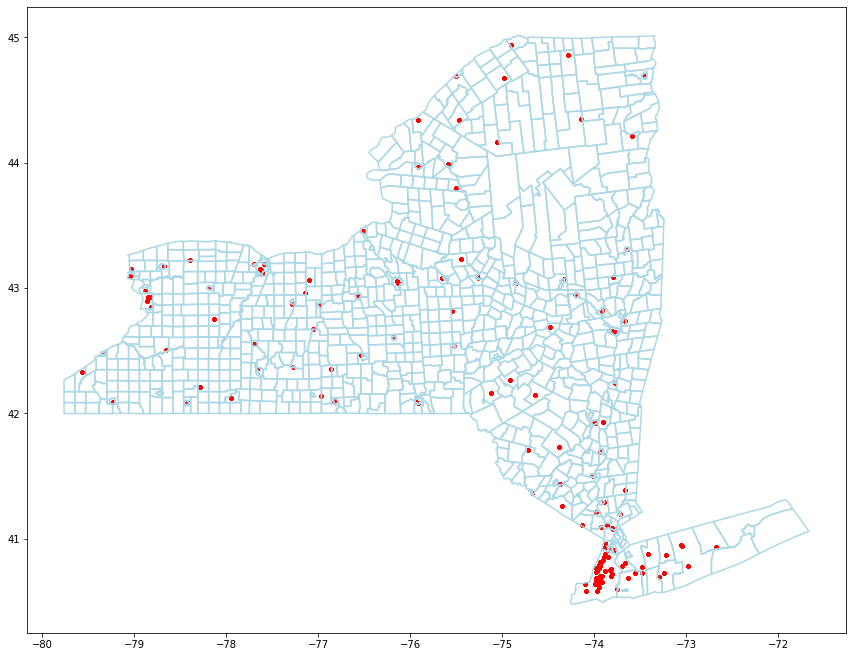

In [30]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

subset = street_map.copy()
subset['pop_density'] = street_map['POP2020']/street_map['CALC_SQ_MI']
fig, ax = plt.subplots(figsize=(20, 18))
x = subset.to_crs(crs)

divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%", pad=0.1)

x.boundary.plot(ax=ax, color='lightblue')
geo_df.plot(ax=ax, markersize=10, color='red', marker="o")
fig.show();


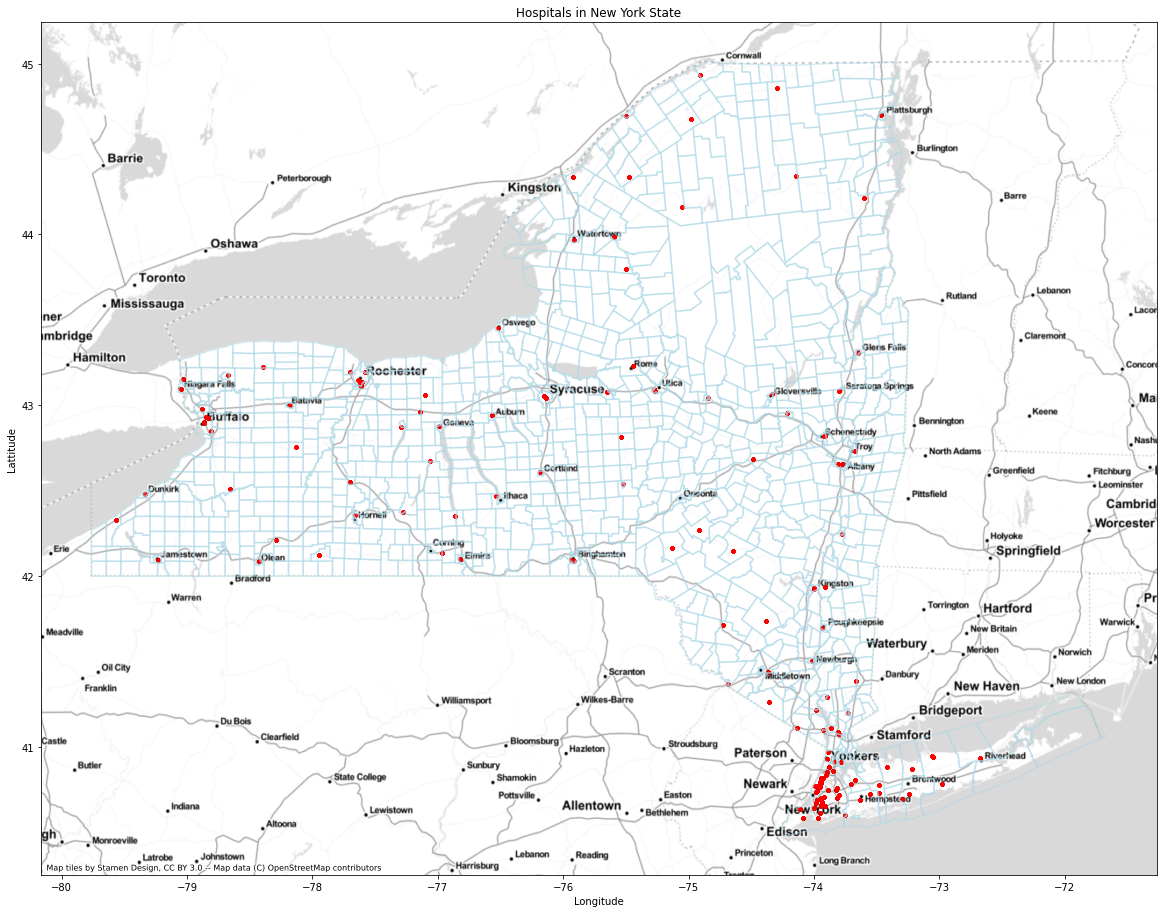

In [33]:
fig,ax = plt.subplots(figsize= (20,18))
x = street_map.to_crs(crs)
x.boundary.plot(ax=ax, alpha=0.5, color='lightblue')
cx.add_basemap(ax, crs=crs, source=cx.providers.Stamen.TonerLite)
geo_df.plot(ax = ax, markersize=10, alpha=0.1, color='red', marker="o")
ax.set(title="Hospitals in New York State", ylabel="Lattitude", xlabel="Longitude")
fig.show();

The above plot gives a good understanding of where the hospitals are concentrated across counties. It will be great to visualize it with population density of each region.

### Plot the distribution of Hospitals and popuplation density together.

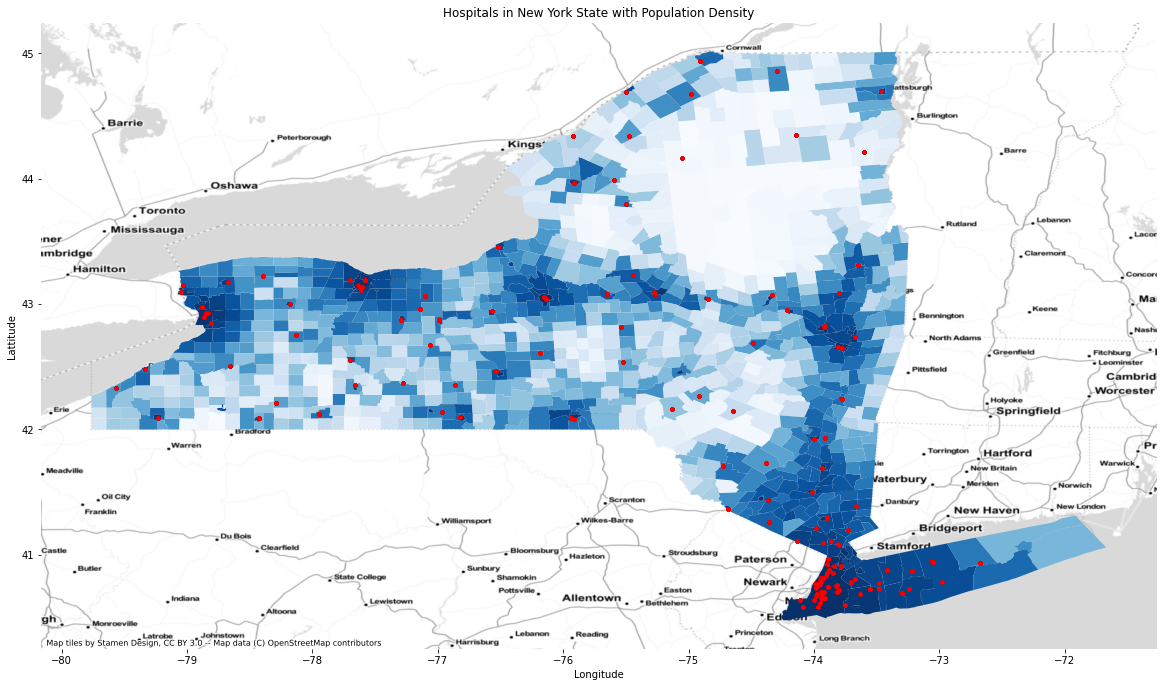

In [29]:

k = 1600 #I find that the more colors, the smoother the viz becomes as data points are spread across gradients
cmap = 'Blues'
figsize=(20,15)
scheme= 'Quantiles'

subset = street_map.copy()
subset['pop_density'] = street_map['POP2020']/street_map['CALC_SQ_MI']

subset = subset.to_crs(crs)
ax = subset.plot(column='pop_density', cmap=cmap, figsize=figsize,
                          scheme=scheme, k=k, legend=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
#Adding Colorbar for legibility

geo_df.plot(ax = ax, markersize=10, alpha=0.1, color='red', marker="o")
# normalize color
vmin, vmax, vcenter = subset.pop_density.min(), subset.pop_density.max(), subset.pop_density.mean()
divnorm = colors.TwoSlopeNorm (vmin=vmin, vcenter=vcenter, vmax=vmax)
# create a normalized colorbar
cbar = plt.cm.ScalarMappable(norm=divnorm, cmap=cmap)
# fig.colorbar(cbar, ax=ax)
ax.set(title="Hospitals in New York State with Population Density", ylabel="Lattitude", xlabel="Longitude")
cx.add_basemap(ax, crs=crs, source=cx.providers.Stamen.TonerLite)
plt.show();